In [1]:
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import time

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition


In [3]:
# file_name = 'movenet_thunder_mobilenet_small'
# file_name = 'movenet_lightning_mobilenet_large'
# file_name = 'movenet_thunder_mobilenet_large'
# file_name = 'movenet_lightning_mobilenet_small'

In [4]:
file_name = "movenet_thunder_mobilenet_large"

In [5]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [6]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [7]:
# shape of the data
print('keypoints shape: ', df['keypoints'].iloc[0].shape)
print('object shape: ', df['object'].iloc[0].shape)
print('obj_vector shape: ', df['obj_vector'].iloc[0].shape)

keypoints shape:  (51,)
object shape:  (5, 1)
obj_vector shape:  (5, 100)


In [8]:
# set to 0 the keypoints with score < 0.3
def filter_keypoints(x):
    x[x[:, 2] < 0.3] = 0
    return x

# df['keypoints'] = df['keypoints'].apply(lambda x: filter_keypoints(x))

# keep only the positions of the keypoints
def get_positions(x):
    return x[:, :2]

# df['keypoints'] = df['keypoints'].apply(lambda x: get_positions(x))

# set to 0 the object with score < 0.1
def filter_object(x):
    x[x[:, 0] < 0.1] = 0
    return x

# df['object'] = df['object'].apply(lambda x: filter_object(x))

In [9]:
# number of object to consider
n_objects = 5

In [10]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object'][-n_objects:]
                                            *x['obj_vector'][-n_objects:], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [11]:
labels = df['category']
    
kpoints = df['keypoints']

df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)

In [12]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

X = np.array(df['input'].to_list())
y = np.array(labels)

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

In [18]:
X_tsne

array([[-76.22266 , -23.363379],
       [ 66.69684 ,  23.107817],
       [-46.19432 ,  -9.245984],
       ...,
       [ 45.60205 , -66.48945 ],
       [ 11.478287, -59.03805 ],
       [ 14.787019,  40.34433 ]], dtype=float32)

In [19]:
y

array([11, 14,  7, ..., 11,  3,  9])

In [20]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'
labels

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

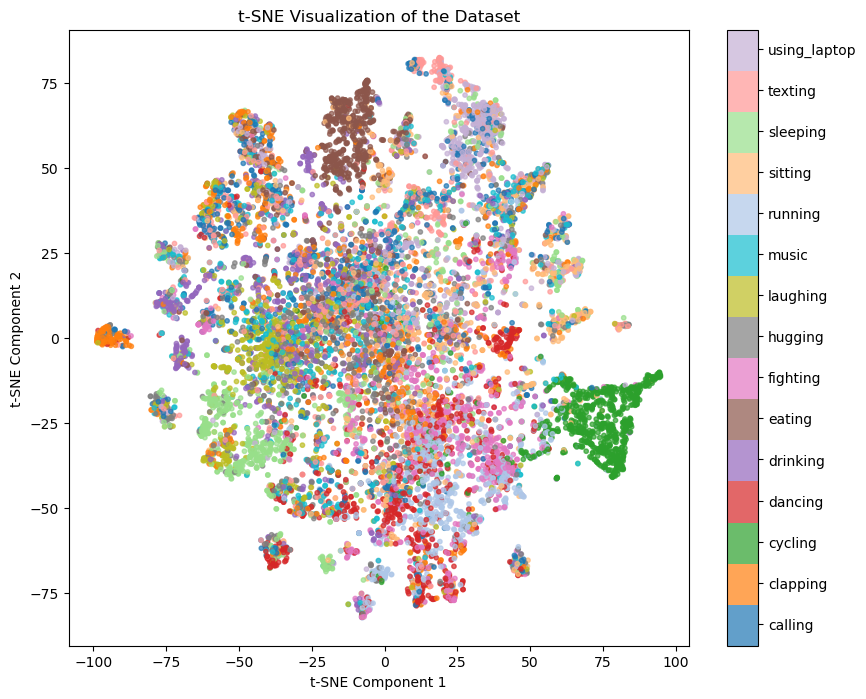

In [17]:
# Plot the t-SNE results
plt.figure(figsize=(10, 8))

from matplotlib.colors import ListedColormap

# Definiamo 15 colori distinti
colors = [
    "#1f77b4",  # blu
    "#ff7f0e",  # arancione
    "#2ca02c",  # verde
    "#d62728",  # rosso
    "#9467bd",  # viola
    "#8c564b",  # marrone
    "#e377c2",  # rosa
    "#7f7f7f",  # grigio
    "#bcbd22",  # giallo-verde
    "#17becf",  # ciano
    "#aec7e8",  # azzurro chiaro
    "#ffbb78",  # arancione chiaro
    "#98df8a",  # verde chiaro
    "#ff9896",  # rosso chiaro
    "#c5b0d5"   # viola chiaro
]

# Creiamo la colormap
cmap = ListedColormap(colors)
                      
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=cmap, s=10, alpha=0.7)

# Create the colorbar
cbar = plt.colorbar(scatter)

# Set the ticks and labels
cbar.set_ticks([0.5 + (14*i/15) for i in range(len(labels))])
cbar.set_ticklabels(labels)

plt.title('t-SNE Visualization of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [94]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_tsne_with_custom_alpha(X_tsne, y, labels, title ,transparency=None, cbar=False, saveplot=False):
    """
    Plots a t-SNE visualization of the dataset with customizable transparency for each class.

    Parameters:
    - X_tsne: 2D numpy array of t-SNE components.
    - y: Array of class labels corresponding to the points in X_tsne.
    - labels: List of class names corresponding to each unique class in y.
    - transparency: Dictionary or list specifying the alpha value for each class.
                    If None, a default alpha value of 0.7 will be used.
    """

    # Define 15 distinct colors
    colors = [
        "#aec7e8", "#ff7f0e", "#2ca02c", "#ff9896", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#1f77b4", "#ffbb78", "#98df8a", "#d62728", "#c5b0d5"
    ]

    # Create the colormap
    cmap = ListedColormap(colors)

    if cbar:
        # Plot the t-SNE results
        plt.figure(figsize=(8, 8))
    else:
        plt.figure(figsize=(6.4, 8))

    # Default alpha value
    if transparency:
        default_alpha = 0.02
    
    else:
        default_alpha = 0.5 

    for i, label in enumerate(labels):
        class_mask = (y == i)

        # Set custom alpha for the class if provided, otherwise use default
        alpha = transparency.get(label, default_alpha) if transparency else default_alpha

        plt.scatter(X_tsne[class_mask, 0], X_tsne[class_mask, 1], 
                    c=[cmap(i)], s=10, alpha=alpha)

    if cbar:
        # Create the colorbar
        scatter = plt.scatter([], [], c=[], cmap=cmap, s=10, alpha=1)
        cbar = plt.colorbar(scatter)

        # Set the ticks and labels
        cbar.set_ticks([(i+0.5)/len(labels) for i in range(len(labels))])
        cbar.set_ticklabels(labels, fontsize = 16)

    # Add titles and labels
    #plt.title(title)
    
    if saveplot:
        plt.savefig(data_directory + '/' + title + '.png', format='png', bbox_inches='tight')
        
    plt.show()

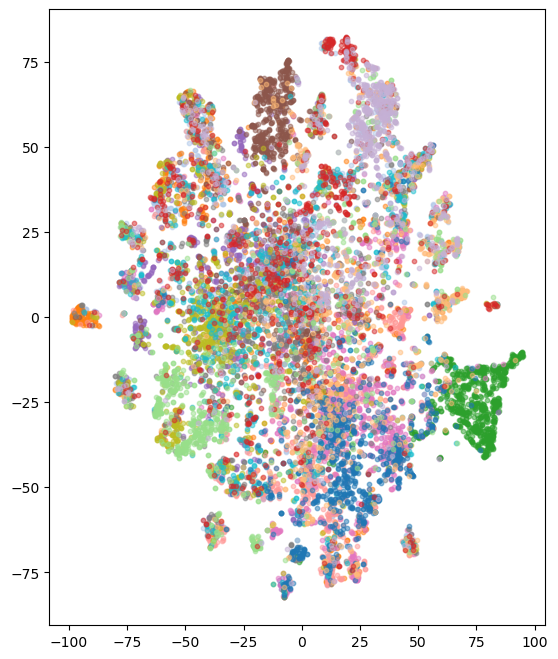

In [96]:
plot_tsne_with_custom_alpha(X_tsne, y, labels, title="t-SNE - All Classes", saveplot=True)

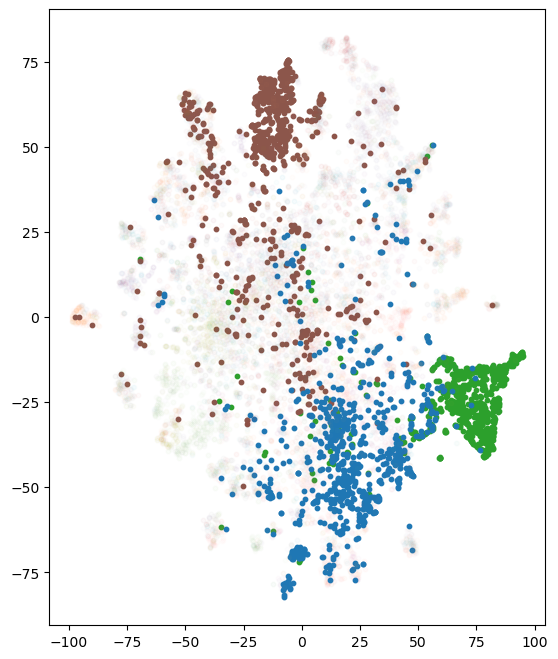

In [91]:
transparency_dict = {'cycling': 1.0, 'eating':1.0, 'running':1.0}
plot_tsne_with_custom_alpha(X_tsne, y, labels, title="t-SNE - Best Performing Classes" , transparency=transparency_dict, saveplot=True)

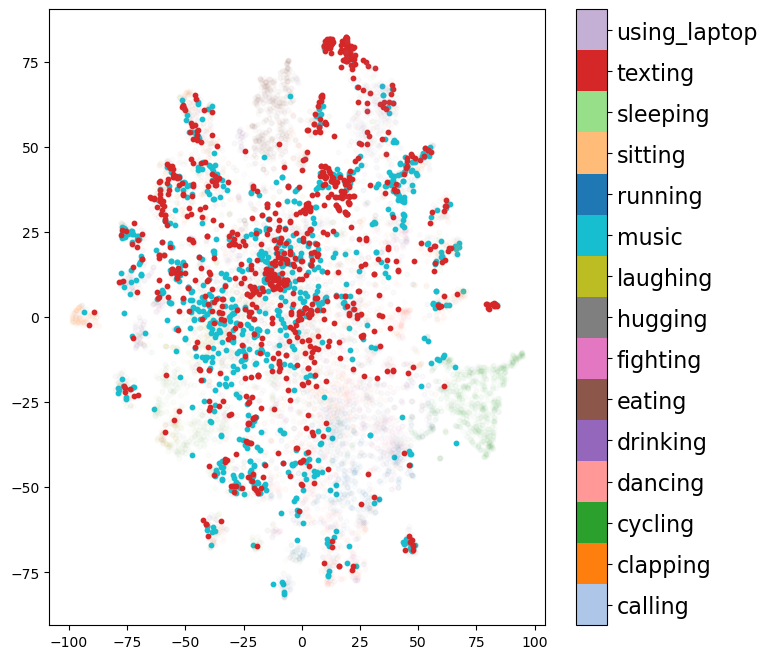

In [93]:
transparency_dict = {'music': 1.0, 'texting':1.0}
plot_tsne_with_custom_alpha(X_tsne, y, labels, transparency=transparency_dict, title= "t-SNE - Worst Performing Classes", cbar=True, saveplot=True)